In [1]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('/kaggle/input/eye-data/All_MOAS_b.csv')
dataset.head()

,Unnamed: 0,File name,Coverage,Instrument,Eye,Rv,Rh,R mean,Limbal sag,HVID,...,0th order phase,1th order phase,2th order phase,3th order phase,4th order phase,5th order phase,6th order phase,7th order phase,8th order phase,9th order phase
0,0,b002,3,P,OD,7.58,7.76,7.670,2.630342,6.0,...,-180,148.907740,-41.325417,-12.397116,-127.276667,-137.973919,-55.299894,134.919585,-136.000808,54.596340
1,1,b003,3,P,OS,7.59,7.70,7.645,2.658090,6.0,...,0,26.434730,49.137943,-102.042505,-160.108101,-0.084489,65.291101,136.083939,131.763609,137.674986
2,2,b004,3,E,OD,9.14,9.61,9.375,2.062922,5.7,...,0,-175.187290,45.209827,-76.612891,113.765733,-100.982681,76.291248,-136.733365,18.339794,-159.808962
3,3,b007,3,P,OD,7.54,8.34,7.940,2.623572,6.1,...,-180,115.944097,166.085786,-123.895958,-29.152433,-134.634709,-110.472582,47.252879,-126.640160,120.584169
4,4,b008,3,P,OS,7.42,8.40,7.910,2.549989,6.0,...,0,59.527858,-150.433337,-53.676870,29.346776,19.960798,29.498263,148.350148,122.617567,114.640640


**Explanation of columns in eye data:**

***File name*** - 1st letter indicates some sort of centering (but missed what)

***Coverage*** - 2&3 give enough coverage of eye, they throw out data points with less (pretty sure he implied that there are no points with lower values in this set)

***Instrument*** - which instrument was used to make the measurement

***Eye*** - OS = left eye, OD = right eye

***RV*** - radius of curvature of eye in vertical plane

***Rh*** - radius of curvature of eye in horizontal plane

***R*** - mean of the two radii of curvature

***Limbal sag*** - height of limbus plane to eye apex

***HVID*** - radius of iris in horizontal plane 

***Edge sag*** - height of the eye's lens to apex of eye

***Toric error*** - error expected between best fit toric lens and the eye (toric is some sort of industry jargon)

***QuadSpec error*** - gives 1st harmonic or 2nd? of ??? allows to address for tilt of lens (that was fitted on by eye doctor???)



In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['Limbal sag', 'HVID', 'Edge sag']
xfeat = dataset.loc[:, features].values #features to explore
scaleData = StandardScaler().fit_transform(xfeat)
#scaler = StandardScaler()
#scaler.fit_transform(xfeat)

# NOTE: MUST use StandardScaler for PCA....although why not just do 3D clustering?
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaleData)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, dataset[['File name']]], axis = 1)

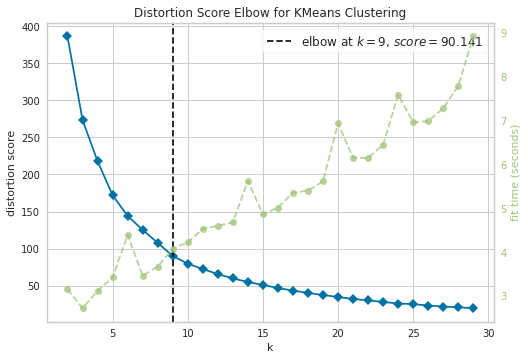

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [3]:
# creating elbow curve for determining optimal k-value
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(init="k-means++", n_init=1000)
visualizer = KElbowVisualizer(kmeans, k=(2, 30))
visualizer.fit(principalComponents)
visualizer.show()

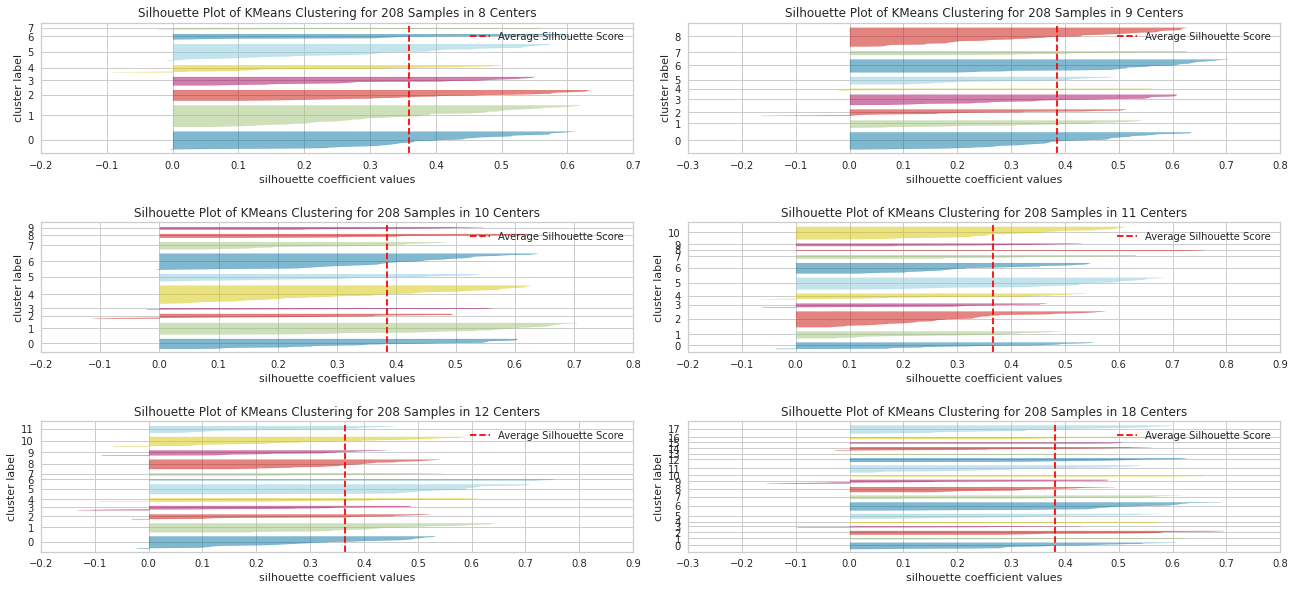

In [4]:
# using Silhouette plot instead to help inform optimal 
# K decision
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(18, 8))
fig.tight_layout(h_pad = 4, w_pad = 2)
curr_row = 0
curr_col = 0
visualgrid = []
for i in [8, 9, 10, 11, 12, 18]:
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init=1000)
    visualgrid.append(SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[curr_row][curr_col]))
    grid_coord = (curr_row, curr_col)
    if(curr_col == 0):
        curr_col = 1
    elif(curr_col == 1):
        curr_row += 1
        curr_col = 0
        
for viz in visualgrid:
    viz.fit(principalComponents)
    viz.finalize()
    for label in viz.ax.texts:
        label.set_size(25)
    #print('For n_clusters = ' + str(i) + ' the average silhouette_score is : ' + str(viz.silhouette_score_))
plt.savefig('shilhouetteScores.png')
plt.show()

From: https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d

1. "For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line). The x-axis represents the Silhouette score." --- ie. all colored 'peaks' should pass red line, this appears to be the case for all k values above
2. "There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points." 

A greater score is better. We see that the max score is obtianed when k = 24 but that yeilds way too many fine clusterings of points and would not be a valid starting set. Closer to the region of the original value of k = 11 we see that k = 9 has the highest score. The same value is also identified from the simpler elbow graph method so this may be a more optimal number of clusters to use intially. 

Note to self: this will obviously change if you want to do a 3D clustering or some other way of doing that with more of the features. 

The figure generated from the original script but with k = 9 is:



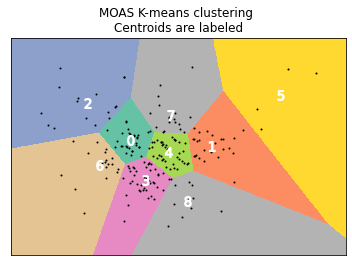


In [5]:
# so doing k-means as before but with k = 9:
kmeans = KMeans(init="k-means++", n_clusters = 9, n_init=1000)
transform = kmeans.fit_transform(principalComponents)
kmeansDf = pd.DataFrame(kmeans.labels_)
kmeansDf.columns = ['cluster']
resData = pd.concat([dataset, kmeansDf], axis = 1)

# resData has all of the original features and data 
# as the input plus a column added for the cluster number
# of each eye

We can now continue to refining our ML predictive model tests. We already saw previously that SVC does not perform well at all so we will not use that one. I also see no reason to use DecisionTree when we can use RandomForest and this data set is not too large. So we will look further into K Nearest Neighbors, Random Forest, and the Naive-Bayes Gaussian model which is supposed to perform well on small datasets. 

In [6]:
y = resData.cluster
features = ['Limbal sag', 'HVID', 'Edge sag']
# Note : see if using all features confuses models
# I do not think it should. 
X = resData[features]

from sklearn.model_selection import train_test_split
# make a train-test split that ensures that there
# is one eye from each cluster in both the train and test sets
i = 0
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = i)
while(len(train_y.unique()) != len(resData.cluster.unique()) or len(test_y.unique()) != len(resData.cluster.unique())):
    i += 1
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = i)
    
print('Number of samples in training set = ' + str(len(train_X)))
print('Number of samples in test set = ' + str(len(test_X)))

Number of samples in training set = 156
Number of samples in test set = 52


---------------
KNN____________________ 0.9615384615
RandomForestClassifier_ 0.9423076923
GaussianNB_____________ 0.9230769231


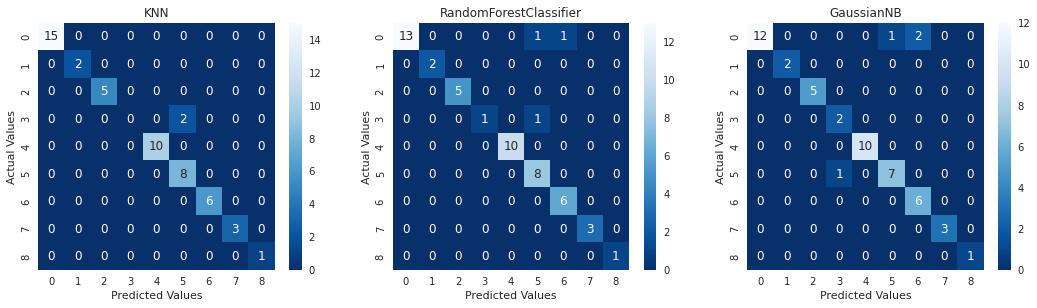

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_pipeline = []
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())
acc_list = []
#auc_list = []
cm_list = []
for model in model_pipeline:
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    acc_list.append(metrics.accuracy_score(test_y, y_pred))
    #fpr, tpr, _thresholds = metrics.roc_curve(val_y, y_pred)
    #auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(test_y, y_pred))
print('---------------')
model_lst = ['KNN', 'RandomForestClassifier', 'GaussianNB']
for i in range(len(model_lst)):
    print('{:_<23s} {:_>10.10f}' .format(model_lst[i], acc_list[i]))
    
    
## plot confusion matrix
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_lst[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap='Blues_r')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')

Great news! The KNN model that was performing poorly when k was 11 is the best one above now.

**k-neighbors hyperparams** : n_neighbors, weights, leaf_size, p

**random forrest hyperparams** : n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap

**gaussianNB hyperparams** : priors, var_smoothing

*NOTE: all of these models have the 'predict_proba(test_X)' method to return the probabilities of a given eye in the test set being in each of the clusters but GaussianNB does not have results that make sense for this. So that eliminates using that model if we want to do this.*

In [8]:
# for KNN, we can only predict the probability of an eye being in a 
# given cluster for the number of clusters equal to the k_neighbors
# hyperprameter, all other probabilities will be lower

# testing accuracy of KNN with n_neighbors at differnet values:
for n in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = n) # default is 5
    knn.fit(train_X, train_y)
    y_pred = knn.predict(test_X)
    # y_preds_probs = knn.predict_proba(test_X)
    acc = metrics.accuracy_score(test_y, y_pred)
    print(str(n) + ' --- ' + str(acc))

knnBest = KNeighborsClassifier(n_neighbors = 3) 
knnBest.fit(train_X, train_y)
y_preds_probs = knn.predict_proba(test_X)
prob = max(y_preds_probs[0])
cluster = (np.where(y_preds_probs[0] == max(y_preds_probs[0]))[0][0])
print('\nFirst test point has probabiliy ' + str(prob) + ' of being in cluster ' + str(cluster))


1 --- 0.9615384615384616
2 --- 0.9615384615384616
3 --- 0.9807692307692307
4 --- 0.9615384615384616
5 --- 0.9615384615384616
6 --- 0.9423076923076923
7 --- 0.9423076923076923
8 --- 0.9423076923076923
9 --- 0.9423076923076923

First test point has probabiliy 0.7777777777777778 of being in cluster 5


One possible way to determine if an eye cannot be classified well is to look at the distribution of probabilities that it belongs to a given cluster. This may identify eyes along a boundary as non-classifieable when in fact out clusters are not very clearly defined anyway so that would not necessarily be the case. Generally, there is no way to do determine if a single point cannot be classified. All we can do is retrain the model periodically.
